In [1]:
# Import Required Modules
import librosa
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D, Input
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Activation
from keras.layers import Bidirectional
from keras.layers import GRU

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# function to extract features from audio file
def getFeaturesTest(filename):

    # Reading File
    y,sr=librosa.load(filename)

    # Mel Frequency Cepstral Coefficients
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)

    # Short Term Fourier Transform
    stft = np.abs(librosa.stft(y))

    # Chromagram from STFT
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)

    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y, sr=sr).T,axis=0)

    # Spectral Contrasts
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0)

    # Tonal Centroid Features
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y),sr=sr).T,axis=0)

    # Flatten the array
    features = np.concatenate((mfcc, chroma, mel, contrast, tonnetz), axis=0)
    return np.array([features])

In [3]:
# Import Dataset
data = pd.read_csv('AudioFeaturesDataset6classes.csv')

# Input Features
x = np.array(data.drop(['Class'], axis=1))

# Label (Output Feature)
y = []
for i in range(data.shape[0]):
	if data.iloc[i, -1] == 'Axecutting_Sounds':
		y.append([1, 0, 0, 0, 0, 0])
	elif data.iloc[i, -1] == 'Chainsaw_Sounds':
		y.append([0, 1, 0, 0, 0, 0])
	elif data.iloc[i, -1] == 'Forest_Sounds':
		y.append([0, 0, 1, 0, 0, 0])
	elif data.iloc[i, -1] == 'Handsaw_Sounds':
		y.append([0, 0, 0, 1, 0, 0])
	elif data.iloc[i, -1] == 'Rain&Thunder_Sounds':
		y.append([0, 0, 0, 0, 1, 0])
	elif data.iloc[i, -1] == 'Wind_Sounds':
		y.append([0, 0, 0, 0, 0, 1])

# Randomize Data
x,y = shuffle(x, np.array(y))

In [4]:
# Splitting data for Training, Testing and Validation
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.15, random_state=101)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.15, random_state=101)

Gated Recurrent Unit Neural Network (GRU) (6 Classes) [Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind]

In [5]:
# Defining Gated Recurrent Unit Neural Network Model (GRU Architecture)
GRU1 = Sequential()

# Fully Connected Layer
GRU1.add(Dense(128, input_shape=(193,1)))

# GRU Layer with 64 Neurons
GRU1.add(GRU(64,return_sequences=False))

# Fully Connected Layer
GRU1.add(Dense(64, activation='relu'))
GRU1.add(Dropout(0.5))

# Output Layer for 4 classes
GRU1.add(Dense(6, activation='softmax'))
GRU1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
GRU1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 193, 128)          256       
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 42,054
Trainable params: 42,054
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Training Gated Recurrent Unit Neural Network (GRU) Model for 6 Classes
start = time.time()
history = GRU1.fit(xtrain, ytrain, batch_size=5, epochs=10, validation_data=(xval,yval))
score, acc = GRU1.evaluate(xtest, ytest, batch_size=5)

Epoch 1/10
1041/1041 [==============================] - 19s 16ms/step - loss: 1.4200 - accuracy: 0.3789 - val_loss: 0.9286 - val_accuracy: 0.6721
Epoch 2/10
1041/1041 [==============================] - 16s 15ms/step - loss: 0.9313 - accuracy: 0.6280 - val_loss: 0.7098 - val_accuracy: 0.7255
Epoch 3/10
1041/1041 [==============================] - 16s 15ms/step - loss: 0.7624 - accuracy: 0.7178 - val_loss: 0.5404 - val_accuracy: 0.7941
Epoch 4/10
1041/1041 [==============================] - 17s 16ms/step - loss: 0.6691 - accuracy: 0.7378 - val_loss: 0.5461 - val_accuracy: 0.7930
Epoch 5/10
1041/1041 [==============================] - 17s 16ms/step - loss: 0.6167 - accuracy: 0.7603 - val_loss: 0.5008 - val_accuracy: 0.7941
Epoch 6/10
1041/1041 [==============================] - 17s 16ms/step - loss: 0.6149 - accuracy: 0.7734 - val_loss: 0.4720 - val_accuracy: 0.7723
Epoch 7/10
1041/1041 [==============================] - 17s 16ms/step - loss: 0.5729 - accuracy: 0.7860 - val_loss: 0.9550 -

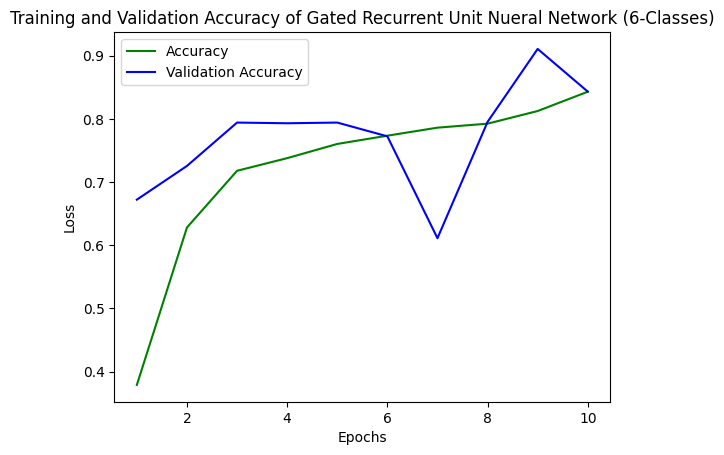

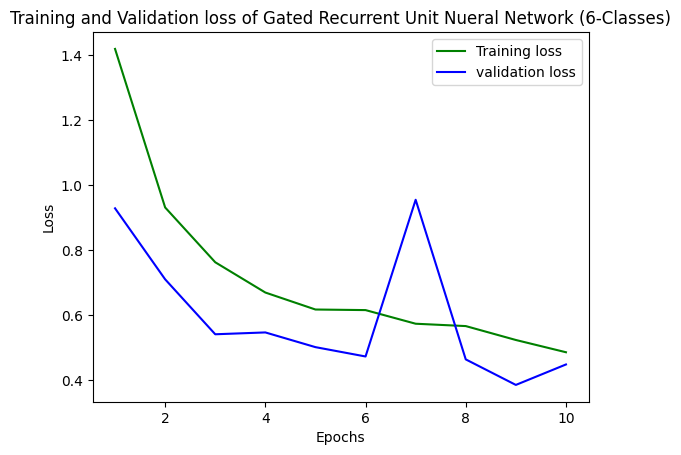

In [7]:
# Training and Validation Accuracy Graph of Gated Recurrent Unit Nueral Network for 6 Classes
train = history.history['accuracy']
val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, train, 'g', label='Accuracy')
plt.plot(epochs, val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of Gated Recurrent Unit Nueral Network (6-Classes)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training and Validation Loss Graph of Gated Recurrent Unit Nueral Network for 6 Classes
train = history.history['loss']
val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, train, 'g', label='Training loss')
plt.plot(epochs, val, 'b', label='validation loss')
plt.title('Training and Validation loss of Gated Recurrent Unit Nueral Network (6-Classes)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Accuracy and Training time of Gated Recurrent Unit Neural Network (GRU) Model for 6 Classes
print('Test score :', score)
print('Test accuracy :', acc)
print('Training took : %d seconds' % int(time.time() - start))

Test score : 0.4917374849319458
Test accuracy : 0.8342592716217041
Training took : 171 seconds


In [9]:
# Classification Report of Gated Recurrent Unit Neural Network (GRU) Model for 6 Classes
ypred = GRU1.predict(xtest)
ypred = np.argmax(ypred, axis=1)
y_test = np.argmax(ytest, axis=1)
creport = classification_report(y_test,ypred)
print(classification_report(y_test,ypred))

34/34 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.69      0.93      0.79       183
           1       0.97      0.90      0.93       192
           2       0.75      0.90      0.82       165
           3       0.92      1.00      0.96       177
           4       0.95      0.82      0.88       187
           5       0.79      0.45      0.57       176

    accuracy                           0.83      1080
   macro avg       0.84      0.83      0.82      1080
weighted avg       0.85      0.83      0.83      1080



163/163 [==============================] - 1s 7ms/step


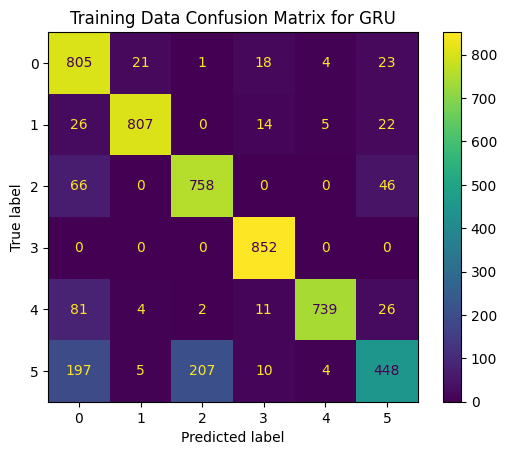

34/34 [==============================] - 0s 7ms/step


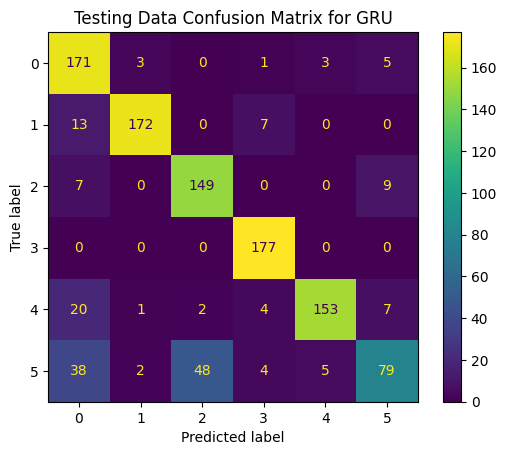

29/29 [==============================] - 0s 6ms/step


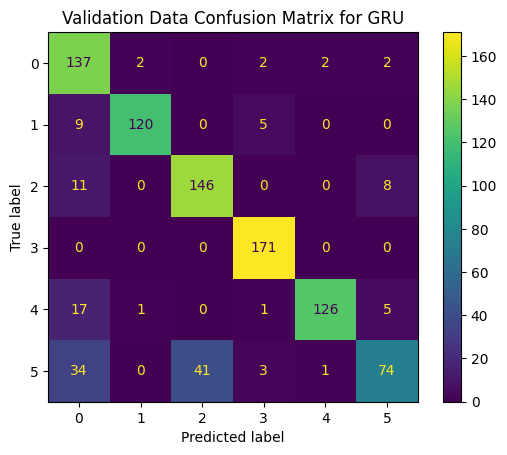

In [10]:
#  Gated Recurrent Unit Neural Network (GRU) Confusion Matrices on 6 Classes data
preds = GRU1.predict(xtrain)
cm = confusion_matrix(np.argmax(ytrain, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Training Data Confusion Matrix for GRU')
plt.show()

preds = GRU1.predict(xtest)
cm = confusion_matrix(np.argmax(ytest, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Testing Data Confusion Matrix for GRU')
plt.show()

preds = GRU1.predict(xval)
cm = confusion_matrix(np.argmax(yval, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Validation Data Confusion Matrix for GRU')
plt.show()

In [11]:
# Custom Testing Gated Recurrent Unit Neural network (GRU) (6 Classes) 
# [1, 0, 0, 0, 0, 0] - Axecutting
# [0, 1, 0, 0, 0, 0] - Chainsaw
# [0, 0, 1, 0, 0, 0] - Forest
# [0, 0, 0, 1, 0, 0] - Handsaw
# [0, 0, 0, 0, 1, 0] - Rain & Thunder
# [0, 0, 0, 0, 0, 1] - Wind

testData = getFeaturesTest('Test Audio data (6 Classes)\Axecutting_test2.wav')
print('Shape of features :', testData.shape)
prediction = GRU1.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Axecutting_test3.wav')
print('Shape of features :', testData.shape)
prediction = GRU1.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Chainsaw_test1.wav')
print('Shape of features :', testData.shape)
prediction = GRU1.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Chainsaw_test4.wav')
print('Shape of features :', testData.shape)
prediction = GRU1.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Forest_test2.wav')
print('Shape of features :', testData.shape)
prediction = GRU1.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Forest_test5.wav')
print('Shape of features :', testData.shape)
prediction = GRU1.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Handsaw_test3.wav')
print('Shape of features :', testData.shape)
prediction = GRU1.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Handsaw_test2.wav')
print('Shape of features :', testData.shape)
prediction = GRU1.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Rain&Thunder_test1.wav')
print('Shape of features :', testData.shape)
prediction = GRU1.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Rain&Thunder_test4.wav')
print('Shape of features :', testData.shape)
prediction = GRU1.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Wind_test3.wav')
print('Shape of features :', testData.shape)
prediction = GRU1.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Wind_test5.wav')
print('Shape of features :', testData.shape)
prediction = GRU1.predict(testData)
print(prediction)

Shape of features : (1, 193)
1/1 [==============================] - 0s 22ms/step
[[9.5071286e-01 3.3567226e-04 2.3022778e-03 2.0397636e-06 1.4264732e-02
  3.2382414e-02]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 22ms/step
[[8.13912332e-01 5.06344857e-03 1.58945024e-02 1.18746284e-04
  4.27806154e-02 1.22230321e-01]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 22ms/step
[[8.4881699e-03 9.8846298e-01 7.9394180e-05 4.5373972e-04 7.3923066e-04
  1.7765458e-03]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 22ms/step
[[2.3541236e-03 9.9517691e-01 1.3538302e-04 8.7680598e-07 6.9116089e-05
  2.2634917e-03]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 22ms/step
[[8.4326557e-06 5.4468132e-13 9.9929786e-01 7.1318680e-21 2.6775945e-10
  6.9366739e-04]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 21ms/step
[[2.5428533e-05 1.2231855e-08 9.6885508e-01 9.8823456e-14 

Bidirectional Gated Recurrent Unit Neural Network (GRU) (6 Classes) [Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind]

In [12]:
# Defining Bidirectional Gated Recurrent Unit Neural Network Model (BI-GRU Architecture)
GRU2 = Sequential()

# Fully Connected Layer
GRU2.add(Dense(128, input_shape=(193,1)))

# Bidirectional GRU Layer with 64 Neurons
GRU2.add(Bidirectional(layer=GRU(32,return_sequences=False),merge_mode='concat'))

# Fully Connected Layer
GRU2.add(Dense(64, activation='relu'))
GRU2.add(Dropout(0.5))

# Output Layer for 4 classes
GRU2.add(Dense(6, activation='softmax'))
GRU2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
GRU2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 193, 128)          256       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               31104     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 35,910
Trainable params: 35,910
Non-trainable params: 0
__________________________________________________

In [13]:
# Training Bidirectional Gated Recurrent Unit Neural Network (BIGRU) Model for 6 Classes
start = time.time()
history = GRU2.fit(xtrain, ytrain, batch_size=5, epochs=10, validation_data=(xval,yval))
score, acc = GRU2.evaluate(xtest, ytest, batch_size=5)

Epoch 1/10
1041/1041 [==============================] - 32s 28ms/step - loss: 1.5041 - accuracy: 0.3799 - val_loss: 1.1283 - val_accuracy: 0.4532
Epoch 2/10
1041/1041 [==============================] - 29s 27ms/step - loss: 0.8926 - accuracy: 0.6888 - val_loss: 0.6337 - val_accuracy: 0.8399
Epoch 3/10
1041/1041 [==============================] - 29s 28ms/step - loss: 0.5416 - accuracy: 0.8401 - val_loss: 0.3129 - val_accuracy: 0.9031
Epoch 4/10
1041/1041 [==============================] - 30s 29ms/step - loss: 0.4317 - accuracy: 0.8731 - val_loss: 0.2755 - val_accuracy: 0.9063
Epoch 5/10
1041/1041 [==============================] - 29s 28ms/step - loss: 0.3786 - accuracy: 0.8862 - val_loss: 0.2503 - val_accuracy: 0.9183
Epoch 6/10
1041/1041 [==============================] - 30s 29ms/step - loss: 0.3264 - accuracy: 0.9008 - val_loss: 0.2861 - val_accuracy: 0.9248
Epoch 7/10
1041/1041 [==============================] - 30s 29ms/step - loss: 0.3128 - accuracy: 0.9062 - val_loss: 0.2176 -

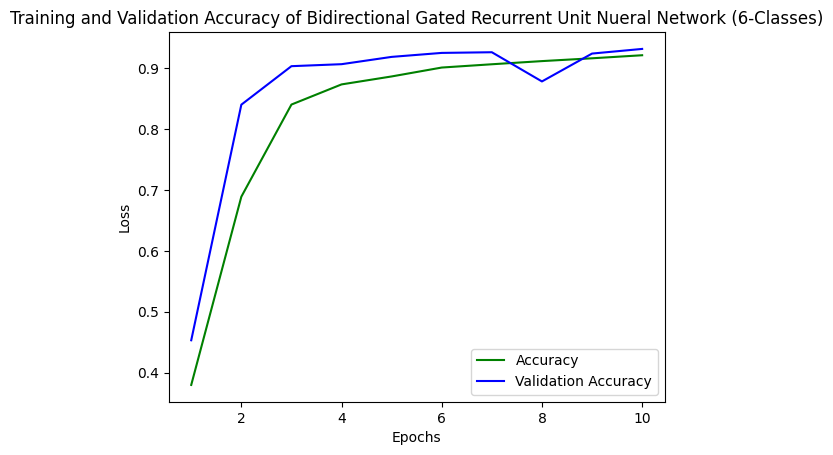

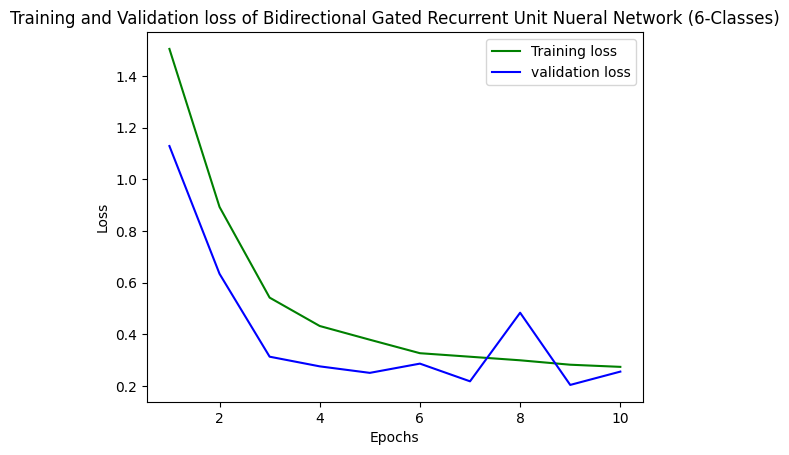

In [14]:
# Training and Validation Accuracy Graph of Bidirectional Gated Recurrent Unit Neural Network for 6 Classes
train = history.history['accuracy']
val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, train, 'g', label='Accuracy')
plt.plot(epochs, val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of Bidirectional Gated Recurrent Unit Nueral Network (6-Classes)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training and Validation Loss Graph of Bidirectional Gated Recurrent Unit Nueral Network for 6 Classes
train = history.history['loss']
val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, train, 'g', label='Training loss')
plt.plot(epochs, val, 'b', label='validation loss')
plt.title('Training and Validation loss of Bidirectional Gated Recurrent Unit Nueral Network (6-Classes)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Accuracy and Training time of Bidirectional Gated Recurrent Unit Neural Network (BIGRU) Model for 6 Classes
print('Test score :', score)
print('Test accuracy :', acc)
print('Training took : %d seconds' % int(time.time() - start))

Test score : 0.26749885082244873
Test accuracy : 0.914814829826355
Training took : 300 seconds


In [16]:
# Classification Report of Bidirectional Gated Recurrent Unit Neural Network (BIGRU) Model for 6 Classes
ypred = GRU2.predict(xtest)
ypred = np.argmax(ypred, axis=1)
y_test = np.argmax(ytest, axis=1)
creport = classification_report(y_test,ypred)
print(classification_report(y_test,ypred))

34/34 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       183
           1       0.99      0.89      0.94       192
           2       0.91      1.00      0.95       165
           3       1.00      0.99      1.00       177
           4       0.80      0.96      0.87       187
           5       0.93      0.78      0.85       176

    accuracy                           0.91      1080
   macro avg       0.92      0.92      0.92      1080
weighted avg       0.92      0.91      0.91      1080



163/163 [==============================] - 2s 12ms/step


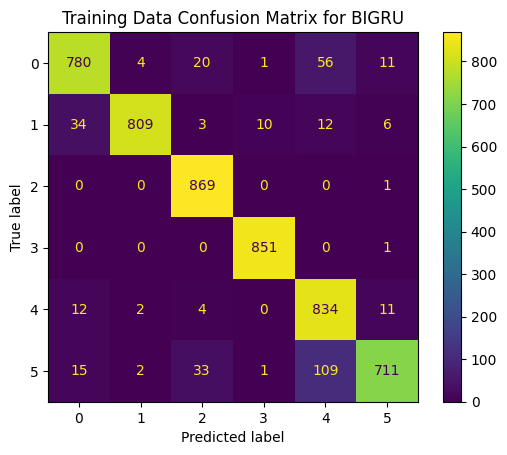

34/34 [==============================] - 0s 12ms/step


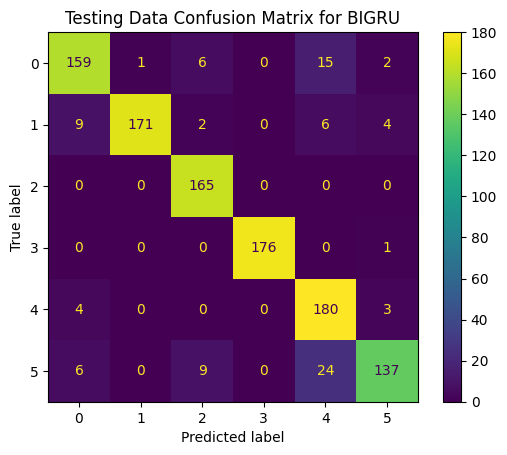

29/29 [==============================] - 0s 13ms/step


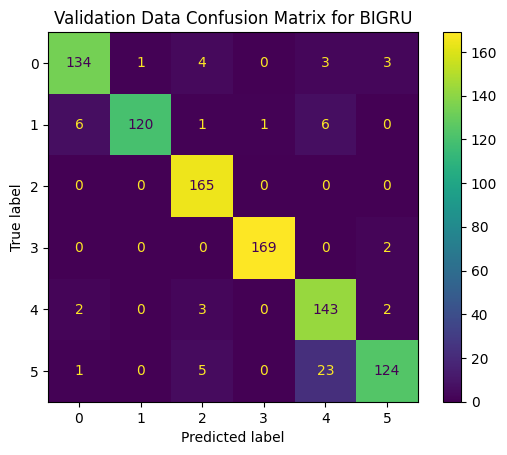

In [17]:
#  Bidirectional Gated Recurrent Unit Neural Network (BIGRU) Confusion Matrices on 6 Classes data
preds = GRU2.predict(xtrain)
cm = confusion_matrix(np.argmax(ytrain, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Training Data Confusion Matrix for BIGRU')
plt.show()

preds = GRU2.predict(xtest)
cm = confusion_matrix(np.argmax(ytest, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Testing Data Confusion Matrix for BIGRU')
plt.show()

preds = GRU2.predict(xval)
cm = confusion_matrix(np.argmax(yval, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Validation Data Confusion Matrix for BIGRU')
plt.show()

In [18]:
# Custom Testing Bi-Directional Gated Recurrent Unit Neural network (BIGRU) (6 Classes) 
# [1, 0, 0, 0, 0, 0] - Axecutting
# [0, 1, 0, 0, 0, 0] - Chainsaw
# [0, 0, 1, 0, 0, 0] - Forest
# [0, 0, 0, 1, 0, 0] - Handsaw
# [0, 0, 0, 0, 1, 0] - Rain & Thunder
# [0, 0, 0, 0, 0, 1] - Wind

testData = getFeaturesTest('Test Audio data (6 Classes)\Axecutting_test2.wav')
print('Shape of features :', testData.shape)
prediction = GRU2.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Axecutting_test3.wav')
print('Shape of features :', testData.shape)
prediction = GRU2.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Chainsaw_test1.wav')
print('Shape of features :', testData.shape)
prediction = GRU2.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Chainsaw_test4.wav')
print('Shape of features :', testData.shape)
prediction = GRU2.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Forest_test2.wav')
print('Shape of features :', testData.shape)
prediction = GRU2.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Forest_test5.wav')
print('Shape of features :', testData.shape)
prediction = GRU2.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Handsaw_test3.wav')
print('Shape of features :', testData.shape)
prediction = GRU2.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Handsaw_test2.wav')
print('Shape of features :', testData.shape)
prediction = GRU2.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Rain&Thunder_test1.wav')
print('Shape of features :', testData.shape)
prediction = GRU2.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Rain&Thunder_test4.wav')
print('Shape of features :', testData.shape)
prediction = GRU2.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Wind_test3.wav')
print('Shape of features :', testData.shape)
prediction = GRU2.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Wind_test5.wav')
print('Shape of features :', testData.shape)
prediction = GRU2.predict(testData)
print(prediction)

Shape of features : (1, 193)
1/1 [==============================] - 0s 50ms/step
[[9.9999952e-01 1.7932171e-10 4.7493597e-07 8.1216621e-16 1.1287444e-09
  4.8565416e-13]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 30ms/step
[[0.33056828 0.00622128 0.02370573 0.00232078 0.46758795 0.16959597]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 25ms/step
[[2.1495565e-04 9.9978358e-01 7.6760550e-08 2.1972990e-07 5.2364948e-07
  6.4688595e-07]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 26ms/step
[[1.2872081e-05 9.9904352e-01 3.0688298e-08 9.4067625e-04 7.1898342e-08
  2.8051270e-06]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 25ms/step
[[2.9176489e-08 1.9289443e-16 9.9996042e-01 4.4718413e-17 2.4203030e-07
  3.9285289e-05]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 24ms/step
[[8.6233030e-07 1.7082493e-12 9.9999845e-01 1.3524740e-15 5.4344227e-11
  7.4389573e

Gated Recurrent Unit Convolutional Neural Network (GRUCNN-1D) (6 Classes) [Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind]

In [19]:
# Defining Gated Recurrent Unit Convolutional Neural Network (GRUCNN-1D) Model
GRU3 = Sequential()

# Convolutional Layer 1 with 64 Neurons and 193 Input Neurons
GRU3.add(Conv1D(64, 3, activation='relu', input_shape=(193,1)))

# Convolutional Layer 2 with 64 Neurons
GRU3.add(Conv1D(64, 3, activation='relu'))

# Pooling Layer 1
GRU3.add(MaxPooling1D(3))

# GRU Layer (CNNGRU) with 64 Neurons
GRU3.add(GRU(64,return_sequences=False))

# Output Layer for 4 classes
GRU3.add(Dense(6, activation='softmax'))
GRU3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
GRU3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 191, 64)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 189, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 64)           0         
 )                                                               
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                                 
Total params: 37,958
Trainable params: 37,958
Non-trainable params: 0
__________________________________________________

In [20]:
# Training Gated Recurrent Unit Convolutional Neural Network (GRUCNN-1D) Model for 6 Classes
start = time.time()
history = GRU3.fit(xtrain, ytrain, batch_size=5, epochs=10, validation_data=(xval,yval))
score, acc = GRU3.evaluate(xtest, ytest, batch_size=5)

Epoch 1/10
1041/1041 [==============================] - 14s 11ms/step - loss: 0.8813 - accuracy: 0.6405 - val_loss: 0.8663 - val_accuracy: 0.6242
Epoch 2/10
1041/1041 [==============================] - 10s 10ms/step - loss: 0.4072 - accuracy: 0.8576 - val_loss: 0.2997 - val_accuracy: 0.8932
Epoch 3/10
1041/1041 [==============================] - 10s 10ms/step - loss: 0.2832 - accuracy: 0.8991 - val_loss: 0.3052 - val_accuracy: 0.8867
Epoch 4/10
1041/1041 [==============================] - 11s 10ms/step - loss: 0.2416 - accuracy: 0.9139 - val_loss: 0.2580 - val_accuracy: 0.9063
Epoch 5/10
1041/1041 [==============================] - 11s 10ms/step - loss: 0.2007 - accuracy: 0.9221 - val_loss: 0.2546 - val_accuracy: 0.9172
Epoch 6/10
1041/1041 [==============================] - 11s 10ms/step - loss: 0.1862 - accuracy: 0.9283 - val_loss: 0.2015 - val_accuracy: 0.9281
Epoch 7/10
1041/1041 [==============================] - 10s 10ms/step - loss: 0.1616 - accuracy: 0.9373 - val_loss: 0.2185 -

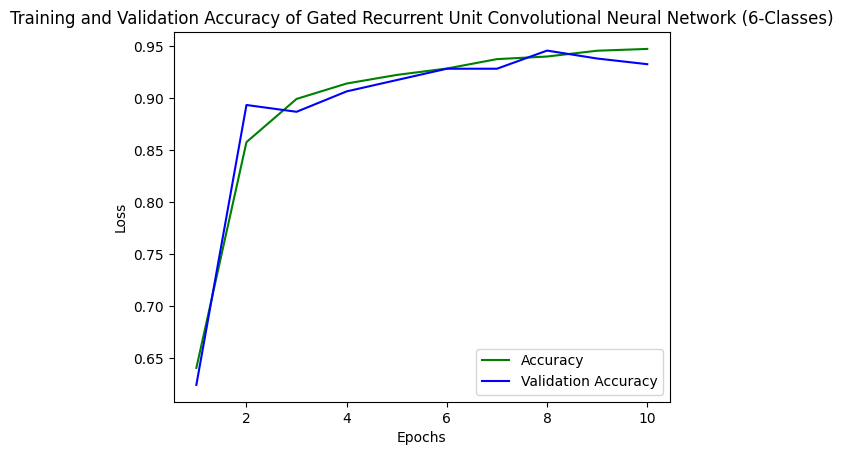

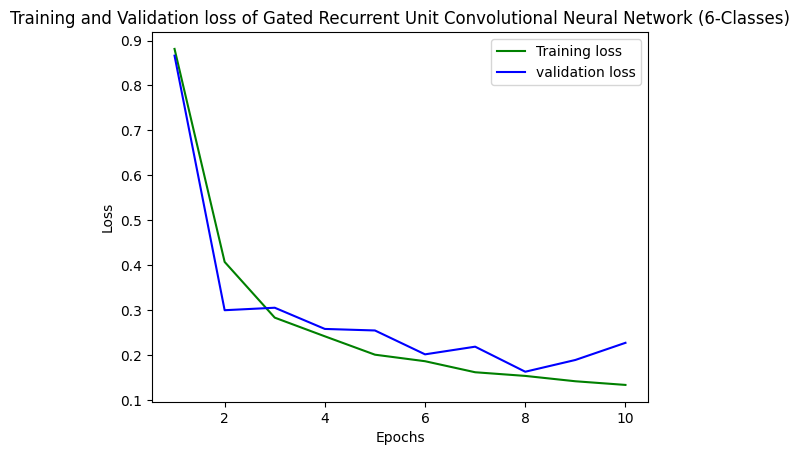

In [21]:
# Training and Validation Accuracy Graph of Gated Recurrent Unit Convolutional Neural Network (GRUCNN-1D) for 6 Classes
train = history.history['accuracy']
val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, train, 'g', label='Accuracy')
plt.plot(epochs, val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of Gated Recurrent Unit Convolutional Neural Network (6-Classes)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training and Validation Loss Graph of Gated Recurrent Unit Convolutional Neural Network for 6 Classes
train = history.history['loss']
val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, train, 'g', label='Training loss')
plt.plot(epochs, val, 'b', label='validation loss')
plt.title('Training and Validation loss of Gated Recurrent Unit Convolutional Neural Network (6-Classes)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Accuracy and Training time of Gated Recurrent Unit Convolutional Neural Network (GRUCNN-1D) Model for 6 Classes
print('Test score:', score)
print('Test accuracy:', acc)
print('Training took: %d seconds' % int(time.time() - start))

Test score: 0.1963469684123993
Test accuracy: 0.9324073791503906
Training took: 109 seconds


In [23]:
# Classification Report of Gated Recurrent Unit Convolutional Neural Network (GRUCNN-1D) Model for 6 Classes
ypred = GRU3.predict(xtest)
ypred = np.argmax(ypred, axis=1)
y_test = np.argmax(ytest, axis=1)
print(classification_report(y_test,ypred))

34/34 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       183
           1       0.97      0.94      0.96       192
           2       0.99      0.96      0.98       165
           3       0.99      1.00      1.00       177
           4       0.91      0.88      0.89       187
           5       0.85      0.87      0.86       176

    accuracy                           0.93      1080
   macro avg       0.93      0.93      0.93      1080
weighted avg       0.93      0.93      0.93      1080



163/163 [==============================] - 1s 4ms/step


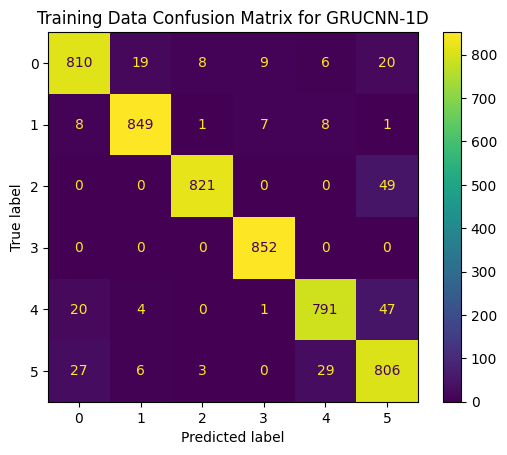

34/34 [==============================] - 0s 4ms/step


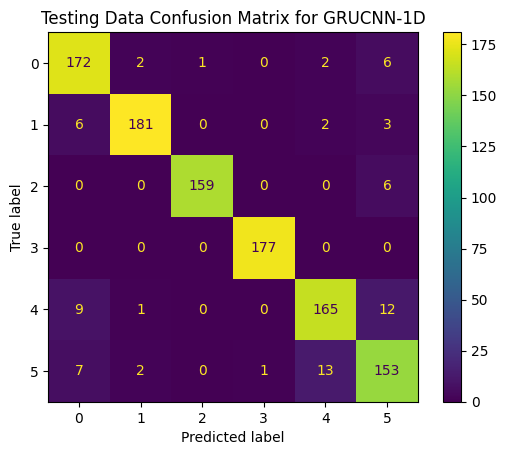

29/29 [==============================] - 0s 9ms/step


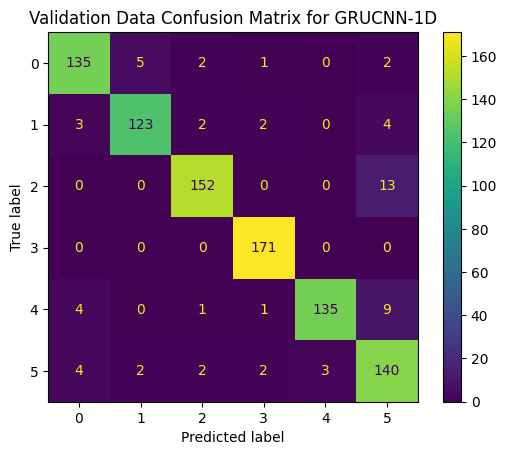

In [24]:
# Gated Recurrent Unit Convolutional Neural Network (GRUCNN-1D) Confusion Matrices on 6 Classes data
preds = GRU3.predict(xtrain)
cm = confusion_matrix(np.argmax(ytrain, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Training Data Confusion Matrix for GRUCNN-1D')
plt.show()

preds = GRU3.predict(xtest)
cm = confusion_matrix(np.argmax(ytest, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Testing Data Confusion Matrix for GRUCNN-1D')
plt.show()

preds = GRU3.predict(xval)
cm = confusion_matrix(np.argmax(yval, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Validation Data Confusion Matrix for GRUCNN-1D')
plt.show()

In [25]:
# Custom Testing Gated Recurrent Unit Convolutional Neural network (GRUCNN-1D) (6 Classes) 
# [1, 0, 0, 0, 0, 0] - Axecutting
# [0, 1, 0, 0, 0, 0] - Chainsaw
# [0, 0, 1, 0, 0, 0] - Forest
# [0, 0, 0, 1, 0, 0] - Handsaw
# [0, 0, 0, 0, 1, 0] - Rain & Thunder
# [0, 0, 0, 0, 0, 1] - Wind

testData = getFeaturesTest('Test Audio data (6 Classes)\Axecutting_test2.wav')
print('Shape of features :', testData.shape)
prediction = GRU3.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Axecutting_test3.wav')
print('Shape of features :', testData.shape)
prediction = GRU3.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Chainsaw_test1.wav')
print('Shape of features :', testData.shape)
prediction = GRU3.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Chainsaw_test4.wav')
print('Shape of features :', testData.shape)
prediction = GRU3.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Forest_test2.wav')
print('Shape of features :', testData.shape)
prediction = GRU3.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Forest_test5.wav')
print('Shape of features :', testData.shape)
prediction = GRU3.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Handsaw_test3.wav')
print('Shape of features :', testData.shape)
prediction = GRU3.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Handsaw_test2.wav')
print('Shape of features :', testData.shape)
prediction = GRU3.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Rain&Thunder_test1.wav')
print('Shape of features :', testData.shape)
prediction = GRU3.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Rain&Thunder_test4.wav')
print('Shape of features :', testData.shape)
prediction = GRU3.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Wind_test3.wav')
print('Shape of features :', testData.shape)
prediction = GRU3.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Wind_test5.wav')
print('Shape of features :', testData.shape)
prediction = GRU3.predict(testData)
print(prediction)

Shape of features : (1, 193)
1/1 [==============================] - 0s 119ms/step
[[9.9832171e-01 3.0172331e-04 3.7584000e-04 1.9395891e-06 1.5163947e-04
  8.4724475e-04]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 21ms/step
[[1.0749825e-01 2.8525242e-03 7.8823129e-03 2.8419763e-06 7.7700877e-04
  8.8098705e-01]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 20ms/step
[[3.1271702e-04 9.9965429e-01 1.2366462e-05 8.2762126e-06 3.4291468e-06
  8.9475843e-06]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 20ms/step
[[4.4778158e-04 9.9953187e-01 1.0455176e-05 7.4406962e-08 2.5545339e-06
  7.3297215e-06]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 19ms/step
[[3.9871000e-05 1.6907336e-05 9.9985361e-01 5.7706401e-08 1.9170375e-06
  8.7681285e-05]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 22ms/step
[[1.7089536e-05 6.2496001e-06 9.9991703e-01 4.2847619e-09 1.755

Bidirectional Gated Recurrent Unit Convolutional Neural Network (BIGRUCNN-1D) (6 Classes) [Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind]

In [26]:
# Defining Bidirectional Gated Recurrent Unit Convolutional Neural Network (BIGRUCNN) (BICNNGRU) Model
GRU4 = Sequential()

# Convolutional Layer 1 with 64 Neurons and 193 Input Neurons
GRU4.add(Conv1D(64, 3, activation='relu', input_shape=(193,1)))

# Convolutional Layer 2 with 64 Neurons
GRU4.add(Conv1D(64, 3, activation='relu'))

# Pooling Layer 1
GRU4.add(MaxPooling1D(3))

# Bidirectional GRU Layer (BIGRUCNN) with 64 Neurons
GRU4.add(Bidirectional(layer=GRU(32,return_sequences=False),merge_mode='concat'))

# Output Layer for 4 classes
GRU4.add(Dense(6, activation='softmax'))
GRU4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
GRU4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 191, 64)           256       
                                                                 
 conv1d_3 (Conv1D)           (None, 189, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 63, 64)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               18816     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 6)                 390       
                                                                 
Total params: 31,814
Trainable params: 31,814
Non-trai

In [27]:
# Training Bidirectional Gated Recurrent Unit Convolutional Neural Network (BIGRUCNN) Model for 6 Classes
start = time.time()
history = GRU4.fit(xtrain, ytrain, batch_size=5, epochs=10, validation_data=(xval,yval))
score, acc = GRU4.evaluate(xtest, ytest, batch_size=5)

Epoch 1/10
1041/1041 [==============================] - 20s 16ms/step - loss: 0.3035 - accuracy: 0.9204 - val_loss: 0.1865 - val_accuracy: 0.9379
Epoch 2/10
1041/1041 [==============================] - 16s 16ms/step - loss: 0.1573 - accuracy: 0.9481 - val_loss: 0.1772 - val_accuracy: 0.9412
Epoch 3/10
1041/1041 [==============================] - 16s 15ms/step - loss: 0.1377 - accuracy: 0.9493 - val_loss: 0.1614 - val_accuracy: 0.9488
Epoch 4/10
1041/1041 [==============================] - 16s 16ms/step - loss: 0.1244 - accuracy: 0.9550 - val_loss: 0.1615 - val_accuracy: 0.9455
Epoch 5/10
1041/1041 [==============================] - 16s 16ms/step - loss: 0.1188 - accuracy: 0.9558 - val_loss: 0.1901 - val_accuracy: 0.9346
Epoch 6/10
1041/1041 [==============================] - 16s 15ms/step - loss: 0.1207 - accuracy: 0.9535 - val_loss: 0.1504 - val_accuracy: 0.9488
Epoch 7/10
1041/1041 [==============================] - 16s 15ms/step - loss: 0.1117 - accuracy: 0.9581 - val_loss: 0.1639 -

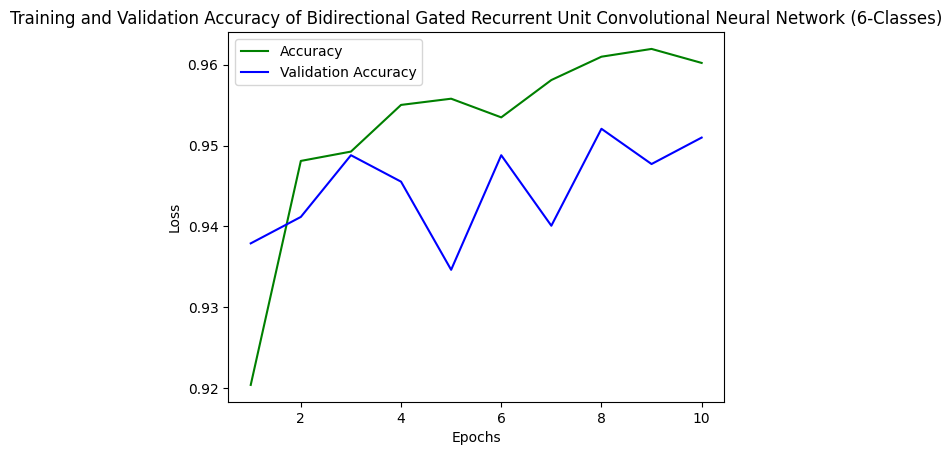

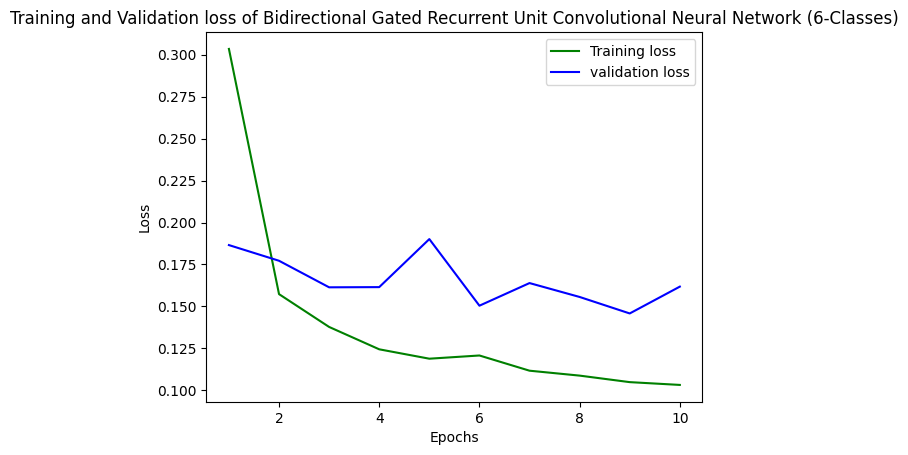

In [28]:
# Training and Validation Accuracy Graph of Bidirectional Gated Recurrent Unit Convolutional Neural Network (BIGRUCNN) for 6 Classes
train = history.history['accuracy']
val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, train, 'g', label='Accuracy')
plt.plot(epochs, val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of Bidirectional Gated Recurrent Unit Convolutional Neural Network (6-Classes)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training and Validation Loss Graph of Bidirectional Gated Recurrent Unit Convolutional Neural Network (BIGRUCNN) for 6 Classes
train = history.history['loss']
val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, train, 'g', label='Training loss')
plt.plot(epochs, val, 'b', label='validation loss')
plt.title('Training and Validation loss of Bidirectional Gated Recurrent Unit Convolutional Neural Network (6-Classes)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Accuracy and Training time of Bidirectional Gated Recurrent Unit Convolutional Neural Network (BIGRUCNN) Model for 6 Classes
print('Test score:', score)
print('Test accuracy:', acc)
print('Training took: %d seconds' % int(time.time() - start))

Test score: 0.1701328307390213
Test accuracy: 0.9425926208496094
Training took: 166 seconds


In [30]:
# Classification Report of Bidirectional Gated Recurrent Unit Convolutional Neural Network (BIGRUCNN) Model for 6 Classes
ypred = GRU4.predict(xtest)
ypred = np.argmax(ypred, axis=1)
y_test = np.argmax(ytest, axis=1)
print(classification_report(y_test,ypred))

34/34 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       183
           1       0.97      0.94      0.95       192
           2       1.00      1.00      1.00       165
           3       1.00      1.00      1.00       177
           4       0.94      0.89      0.92       187
           5       0.81      0.93      0.86       176

    accuracy                           0.94      1080
   macro avg       0.95      0.94      0.94      1080
weighted avg       0.95      0.94      0.94      1080



163/163 [==============================] - 1s 6ms/step


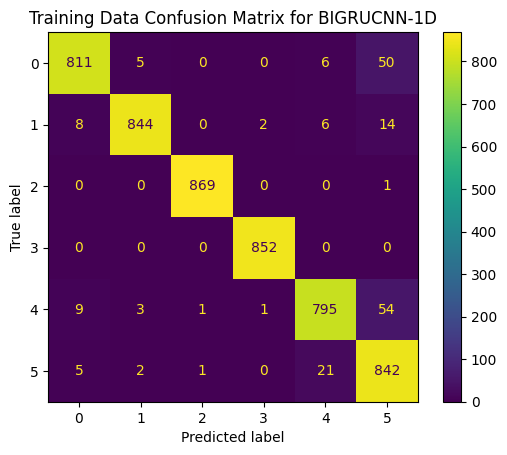

34/34 [==============================] - 0s 5ms/step


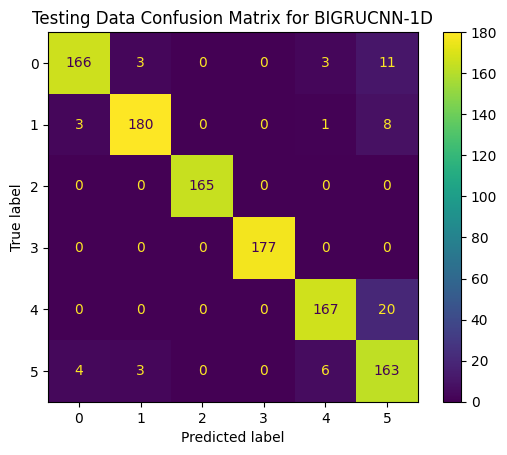

29/29 [==============================] - 0s 5ms/step


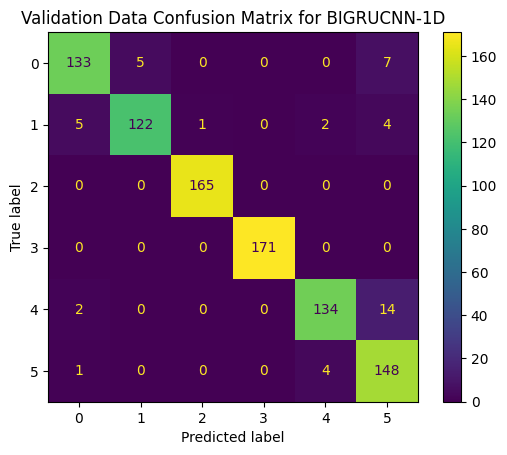

In [31]:
# Bidirectional Gated Recurrent Unit Convolutional Neural Network (BIGRUCNN) Confusion Matrices on 6 Classes data
preds = GRU4.predict(xtrain)
cm = confusion_matrix(np.argmax(ytrain, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Training Data Confusion Matrix for BIGRUCNN-1D')
plt.show()

preds = GRU4.predict(xtest)
cm = confusion_matrix(np.argmax(ytest, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Testing Data Confusion Matrix for BIGRUCNN-1D')
plt.show()

preds = GRU4.predict(xval)
cm = confusion_matrix(np.argmax(yval, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Validation Data Confusion Matrix for BIGRUCNN-1D')
plt.show()

In [32]:
# Custom Testing Bi-Directional Gated Recurrent Unit Convolutional Neural network (BIGRUCNN-1D) (6 Classes) 
# [1, 0, 0, 0, 0, 0] - Axecutting
# [0, 1, 0, 0, 0, 0] - Chainsaw
# [0, 0, 1, 0, 0, 0] - Forest
# [0, 0, 0, 1, 0, 0] - Handsaw
# [0, 0, 0, 0, 1, 0] - Rain & Thunder
# [0, 0, 0, 0, 0, 1] - Wind

testData = getFeaturesTest('Test Audio data (6 Classes)\Axecutting_test2.wav')
print('Shape of features :', testData.shape)
prediction = GRU4.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Axecutting_test3.wav')
print('Shape of features :', testData.shape)
prediction = GRU4.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Chainsaw_test1.wav')
print('Shape of features :', testData.shape)
prediction = GRU4.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Chainsaw_test4.wav')
print('Shape of features :', testData.shape)
prediction = GRU4.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Forest_test2.wav')
print('Shape of features :', testData.shape)
prediction = GRU4.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Forest_test5.wav')
print('Shape of features :', testData.shape)
prediction = GRU4.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Handsaw_test3.wav')
print('Shape of features :', testData.shape)
prediction = GRU4.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Handsaw_test2.wav')
print('Shape of features :', testData.shape)
prediction = GRU4.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Rain&Thunder_test1.wav')
print('Shape of features :', testData.shape)
prediction = GRU4.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Rain&Thunder_test4.wav')
print('Shape of features :', testData.shape)
prediction = GRU4.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Wind_test3.wav')
print('Shape of features :', testData.shape)
prediction = GRU4.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Wind_test5.wav')
print('Shape of features :', testData.shape)
prediction = GRU4.predict(testData)
print(prediction)

Shape of features : (1, 193)
1/1 [==============================] - 0s 38ms/step
[[9.88865256e-01 1.11676396e-04 9.38874928e-06 6.22535836e-08
  3.45194084e-03 7.56174512e-03]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 21ms/step
[[1.7228924e-01 1.2771984e-03 5.6269753e-04 1.7520186e-05 2.5466624e-01
  5.7118708e-01]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 27ms/step
[[2.1520699e-03 9.9557412e-01 7.3123560e-06 8.0331965e-06 8.8525523e-04
  1.3732875e-03]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 41ms/step
[[1.3365605e-04 9.9924552e-01 3.5256838e-07 9.2306263e-06 2.0187467e-04
  4.0949017e-04]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 21ms/step
[[4.2479816e-05 1.2585407e-04 9.9927658e-01 4.7948660e-08 1.0478662e-04
  4.5035829e-04]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 23ms/step
[[2.57603951e-05 4.04563343e-06 9.99862671e-01 6.08354167e

Residual Network (ResNet-34) (6 Classes) [Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind]

In [33]:
# Defining Residual Network Model Architecture (ResNet-34)
n_feature_maps = 64

input_shape = (193,1)
input_layer = Input(input_shape)

# BLOCK 1
conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)
conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)
conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)
# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
output_block_1 = keras.layers.add([shortcut_y, conv_z])
output_block_1 = keras.layers.Activation('relu')(output_block_1)

# BLOCK 2
conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)
conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)
conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)
# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
output_block_2 = keras.layers.add([shortcut_y, conv_z])
output_block_2 = keras.layers.Activation('relu')(output_block_2)

# BLOCK 3
conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)
conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)
conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)
# no need to expand channels because they are equal
shortcut_y = keras.layers.BatchNormalization()(output_block_2)
output_block_3 = keras.layers.add([shortcut_y, conv_z])
output_block_3 = keras.layers.Activation('relu')(output_block_3)

# FINAL BLOCK
gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)
output_layer = keras.layers.Dense(6, activation='softmax')(gap_layer)
resnet = keras.models.Model(inputs=input_layer, outputs=output_layer)

resnet.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 193, 1)]     0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 193, 64)      576         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 193, 64)     256         ['conv1d_4[0][0]']               
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 193, 64)      0           ['batch_normalization[0][0]']

In [34]:
# Training Residual Network Model for 6 Classes
start = time.time()
history = resnet.fit(xtrain, ytrain, batch_size=5, epochs=10, validation_data=(xval,yval))
score, acc = resnet.evaluate(xtest, ytest, batch_size=5)

Epoch 1/10
1041/1041 [==============================] - 24s 20ms/step - loss: 0.4382 - accuracy: 0.8685 - val_loss: 0.4500 - val_accuracy: 0.8486
Epoch 2/10
1041/1041 [==============================] - 19s 18ms/step - loss: 0.2266 - accuracy: 0.9329 - val_loss: 0.3723 - val_accuracy: 0.9248
Epoch 3/10
1041/1041 [==============================] - 21s 20ms/step - loss: 0.1844 - accuracy: 0.9437 - val_loss: 0.1804 - val_accuracy: 0.9346
Epoch 4/10
1041/1041 [==============================] - 21s 20ms/step - loss: 0.1654 - accuracy: 0.9466 - val_loss: 0.5059 - val_accuracy: 0.8671
Epoch 5/10
1041/1041 [==============================] - 20s 20ms/step - loss: 0.1473 - accuracy: 0.9502 - val_loss: 0.3540 - val_accuracy: 0.8105
Epoch 6/10
1041/1041 [==============================] - 20s 19ms/step - loss: 0.1396 - accuracy: 0.9535 - val_loss: 1.8720 - val_accuracy: 0.7026
Epoch 7/10
1041/1041 [==============================] - 21s 20ms/step - loss: 0.1373 - accuracy: 0.9512 - val_loss: 2.3063 -

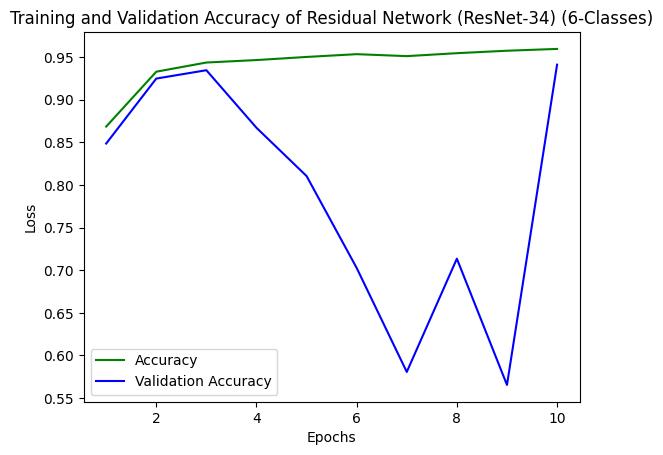

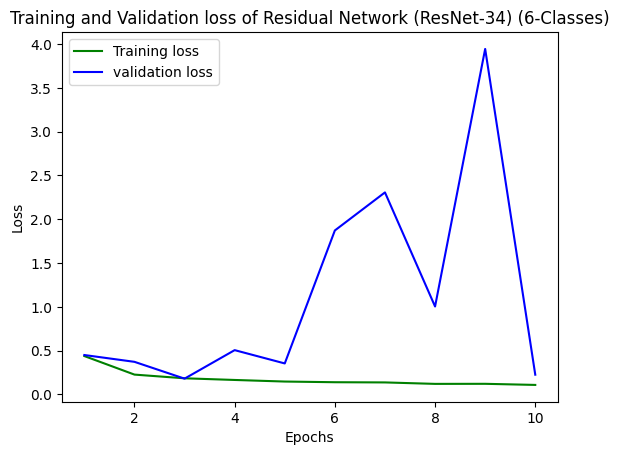

In [35]:
# Training and Validation Accuracy Graph of Residual Network (ResNet-34) for 6 Classes
train = history.history['accuracy']
val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, train, 'g', label='Accuracy')
plt.plot(epochs, val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of Residual Network (ResNet-34) (6-Classes)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training and Validation Loss Graph of Residual Network (ResNet-34) for 6 Classes
train = history.history['loss']
val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, train, 'g', label='Training loss')
plt.plot(epochs, val, 'b', label='validation loss')
plt.title('Training and Validation loss of Residual Network (ResNet-34) (6-Classes)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Accuracy and Training time of Residual Network (ResNet-34) for 6 Classes
print('Test score:', score)
print('Test accuracy:', acc)
print('Training took: %d seconds' % int(time.time() - start))

Test score: 0.2142425924539566
Test accuracy: 0.9305555820465088
Training took: 211 seconds


In [37]:
# Classification Report of Residual Network (ResNet-34) for 6 Classes
ypred = resnet.predict(xtest)
ypred = np.argmax(ypred, axis=1)
y_test = np.argmax(ytest, axis=1)
print(classification_report(y_test,ypred))

34/34 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       183
           1       0.99      0.88      0.93       192
           2       1.00      1.00      1.00       165
           3       0.99      1.00      0.99       177
           4       0.79      0.98      0.88       187
           5       0.99      0.82      0.90       176

    accuracy                           0.93      1080
   macro avg       0.94      0.93      0.93      1080
weighted avg       0.94      0.93      0.93      1080



163/163 [==============================] - 1s 8ms/step


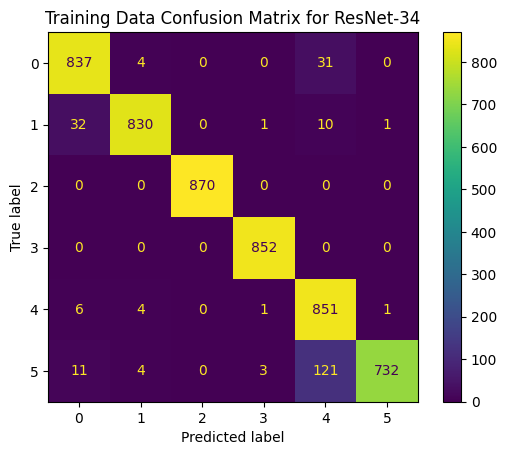

34/34 [==============================] - 0s 6ms/step


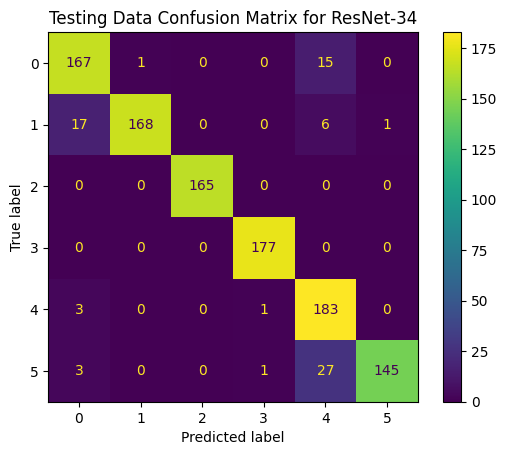

29/29 [==============================] - 1s 20ms/step


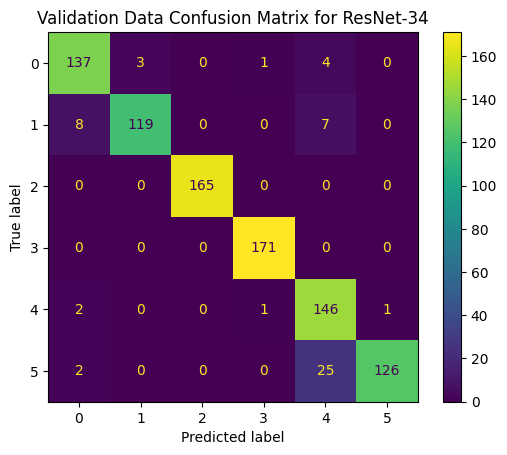

In [38]:
# Residual Network (ResNet-34) Confusion Matrices on 6 Classes data
preds = resnet.predict(xtrain)
cm = confusion_matrix(np.argmax(ytrain, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Training Data Confusion Matrix for ResNet-34')
plt.show()

preds = resnet.predict(xtest)
cm = confusion_matrix(np.argmax(ytest, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Testing Data Confusion Matrix for ResNet-34')
plt.show()

preds = resnet.predict(xval)
cm = confusion_matrix(np.argmax(yval, axis=1), np.argmax(preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Validation Data Confusion Matrix for ResNet-34')
plt.show()

In [39]:
# Custom Testing Residual Network (ResNet-34) (6 Classes) 
# [1, 0, 0, 0, 0, 0] - Axecutting
# [0, 1, 0, 0, 0, 0] - Chainsaw
# [0, 0, 1, 0, 0, 0] - Forest
# [0, 0, 0, 1, 0, 0] - Handsaw
# [0, 0, 0, 0, 1, 0] - Rain & Thunder
# [0, 0, 0, 0, 0, 1] - Wind

testData = getFeaturesTest('Test Audio data (6 Classes)\Axecutting_test2.wav')
print('Shape of features :', testData.shape)
prediction = resnet.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Axecutting_test3.wav')
print('Shape of features :', testData.shape)
prediction = resnet.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Chainsaw_test1.wav')
print('Shape of features :', testData.shape)
prediction = resnet.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Chainsaw_test4.wav')
print('Shape of features :', testData.shape)
prediction = resnet.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Forest_test2.wav')
print('Shape of features :', testData.shape)
prediction = resnet.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Forest_test5.wav')
print('Shape of features :', testData.shape)
prediction = resnet.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Handsaw_test3.wav')
print('Shape of features :', testData.shape)
prediction = resnet.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Handsaw_test2.wav')
print('Shape of features :', testData.shape)
prediction = resnet.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Rain&Thunder_test1.wav')
print('Shape of features :', testData.shape)
prediction = resnet.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Rain&Thunder_test4.wav')
print('Shape of features :', testData.shape)
prediction = resnet.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Wind_test3.wav')
print('Shape of features :', testData.shape)
prediction = resnet.predict(testData)
print(prediction)

testData = getFeaturesTest('Test Audio data (6 Classes)\Wind_test5.wav')
print('Shape of features :', testData.shape)
prediction = resnet.predict(testData)
print(prediction)

Shape of features : (1, 193)
1/1 [==============================] - 0s 246ms/step
[[9.9790764e-01 8.9423236e-04 3.3406494e-07 1.6152192e-04 1.0110581e-03
  2.5255777e-05]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 20ms/step
[[3.0474046e-01 1.8929789e-02 2.3352183e-04 2.6425640e-03 6.3317448e-01
  4.0279165e-02]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 19ms/step
[[2.7018157e-03 9.9646384e-01 8.5460724e-06 5.3253556e-05 5.8135658e-04
  1.9126147e-04]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 19ms/step
[[1.2993942e-03 9.9847883e-01 4.7340718e-09 1.9023802e-12 1.3340330e-04
  8.8381799e-05]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 19ms/step
[[5.6095082e-06 4.6555357e-04 9.9906462e-01 4.0287687e-04 5.6663372e-05
  4.6754149e-06]]
Shape of features : (1, 193)
1/1 [==============================] - 0s 20ms/step
[[6.3871447e-04 4.0641078e-04 9.9813473e-01 2.0771867e-04 5.301

In [40]:
print("\n1 - Gated Recurrent Unit Neural Network (GRU) Metrics for 6 classes is (Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind): ")
score, acc = GRU1.evaluate(xtest, ytest, batch_size=5)
print('    Accuracy:', acc)
print('    Loss:', score)

print("\n2 - Bi-Directional Gated Recurrent Unit Neural Network (BIGRU) Metrics for 6 classes is (Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind): ")
score, acc = GRU2.evaluate(xtest, ytest, batch_size=5)
print('    Accuracy:', acc)
print('    Loss:', score)

print("\n3 - Gated Recurrent Unit Convolutional Neural Network (GRUCNN-1D) Metrics for 6 classes is (Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind): ")
score, acc = GRU3.evaluate(xtest, ytest, batch_size=5)
print('    Accuracy:', acc)
print('    Loss:', score)

print("\n4 - Bi-Directional Gated Recurrent Unit Convolutional Neural Network (BIGRUCNN-1D) Metrics for 6 classes is (Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind): ")
score, acc = GRU4.evaluate(xtest, ytest, batch_size=5)
print('    Accuracy:', acc)
print('    Loss:', score)

print("\n5 - Residual Network (ResNet-34) Metrics for 6 classes is (Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind): ")
score, acc = resnet.evaluate(xtest, ytest, batch_size=5)
print('    Accuracy:', acc)
print('    Loss:', score)


1 - Gated Recurrent Unit Neural Network (GRU) Metrics for 6 classes is (Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind): 
216/216 [==============================] - 2s 9ms/step - loss: 0.4917 - accuracy: 0.8343
    Accuracy: 0.8342592716217041
    Loss: 0.4917374849319458

2 - Bi-Directional Gated Recurrent Unit Neural Network (BIGRU) Metrics for 6 classes is (Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind): 
216/216 [==============================] - 3s 12ms/step - loss: 0.2675 - accuracy: 0.9148
    Accuracy: 0.914814829826355
    Loss: 0.26749885082244873

3 - Gated Recurrent Unit Convolutional Neural Network (GRUCNN-1D) Metrics for 6 classes is (Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind): 
216/216 [==============================] - 1s 4ms/step - loss: 0.1963 - accuracy: 0.9324
    Accuracy: 0.9324073791503906
    Loss: 0.1963469684123993

4 - Bi-Directional Gated Recurrent Unit Convolutional Neural Network (BIGRUCNN-1D) Metrics for 6 cla